Setting refAnt: CS201HBA0
Loaded 58 antennas, 3595 times, 34 directions
Setting refAnt: CS201HBA0
flagged ['CS201HBA1', 'CS201HBA0', 'CS021HBA1', 'CS021HBA0', 'CS011HBA0', 'CS011HBA1', 'CS030HBA1', 'CS030HBA0', 'RS406HBA', 'RS307HBA', 'CS004HBA0', 'CS004HBA1', 'RS106HBA', 'CS026HBA0', 'CS026HBA1', 'CS301HBA0', 'CS301HBA1', 'CS101HBA0', 'CS101HBA1', 'CS024HBA0', 'CS024HBA1', 'CS401HBA0', 'CS032HBA1', 'CS032HBA0', 'CS028HBA0', 'CS028HBA1', 'CS001HBA1', 'CS001HBA0', 'RS503HBA', 'CS103HBA0', 'CS103HBA1', 'CS003HBA1', 'CS003HBA0', 'RS306HBA', 'CS002HBA0', 'CS002HBA1', 'RS205HBA', 'CS501HBA0', 'CS501HBA1', 'RS305HBA', 'CS005HBA1', 'CS005HBA0', 'CS006HBA0', 'CS006HBA1', 'CS302HBA1', 'CS302HBA0', 'CS017HBA0', 'CS017HBA1', 'CS031HBA0', 'CS031HBA1']
Setting refAnt: CS401HBA1
Loaded 8 antennas, 3595 times, 34 directions
Setting refAnt: CS401HBA1
flagged ['s1', 's2', 's251', 's252', 's253', 's254', 's8', 's23', 's3', 's10', 's5', 's7', 's9', 's6', 's27', 's22', 's26', 's15', 's17', 's281', 's24', 

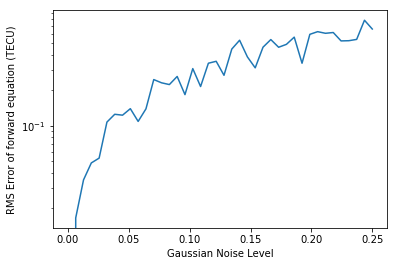

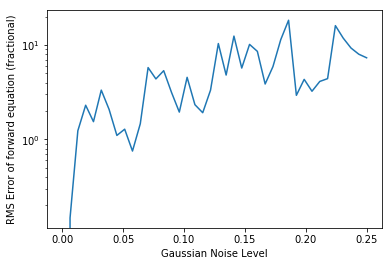

In [4]:
import numpy as np
from scipy.integrate import simps
import dask.array as da
from dask import delayed
from dask.multiprocessing import get

def doForwardEquation(rays,K_ne,mTCI):
    N1,N2, _ , Ns = rays.shape
    nevec = np.zeros(Ns,dtype=np.double)
    g = np.zeros([N1,N2],dtype=np.double)
    j = 0
    while j < N1:
        k = 0
        while k < N2:
            x = rays[j,k,0,:]
            y = rays[j,k,1,:]
            z = rays[j,k,2,:]
            s = rays[j,k,3,:]
            nevec *= 0
            idx = 0
            while idx < Ns:
                nevec[idx] += mTCI.interp(x[idx],y[idx],z[idx])
                idx += 1
            
            np.exp(nevec,out=nevec)
            nevec *= K_ne
            g[j,k] += simps(nevec,s)
            k += 1
        j += 1
    g /= 1e13
    return g
                

def forwardEquation(rays,K_ne,mTCI,i0):
    '''For each ray do the forward equation using ref antenna i0'''
    Na,Nt,Nd, _, Ns = rays.shape
    if Na < Nd:
        #do over antennas
        tec = np.stack([doForwardEquation(rays[i,:,:,:,:],K_ne,mTCI) for i in range(Na)],axis=0)
    else:
        #do over directions
        tec = np.stack([doForwardEquation(rays[:,:,k,:,:],K_ne,mTCI) for k in range(Nd)],axis=2)
    dtec = tec - tec[i0,:,:]
    return dtec

def forwardEquation_dask(rays,K_ne,mTCI,i0):
    '''For each ray do the forward equation using ref antenna i0'''
    Na,Nt,Nd, _, Ns = rays.shape
    if Na < Nd:
        #do over antennas
        tec = da.stack([da.from_delayed(delayed(doForwardEquation)(rays[i,:,:,:,:],K_ne,mTCI),(Nt,Nd),dtype=np.double) for i in range(Na)],axis=0)
    else:
        #do over directions
        tec = da.stack([da.from_delayed(delayed(doForwardEquation)(rays[:,:,k,:,:],K_ne,mTCI),(Na,Nt),dtype=np.double) for k in range(Nd)],axis=2)
    dtec = tec - tec[i0,:,:]
    return dtec.compute(get=get)

def test_forwardEquation():
    from TricubicInterpolation import TriCubic
    from RealData import DataPack
    from AntennaFacetSelection import selectAntennaFacets
    from CalcRays import calcRays
    import pylab as plt
    datapack = DataPack(filename="output/test/datapackObs.hdf5")
    datapackSel = selectAntennaFacets(8, datapack, antIdx=-1, dirIdx=-1, timeIdx = [0])
    antennas,antennaLabels = datapackSel.get_antennas(antIdx = -1)
    patches, patchNames = datapackSel.get_directions(dirIdx = -1)
    times,timestamps = datapackSel.get_times(timeIdx=[0])
    Na = len(antennas)
    Nt = len(times)
    Nd = len(patches)  
    fixtime = times[Nt>>1]
    phase = datapack.getCenterDirection()
    arrayCenter = datapack.radioArray.getCenter()
    neTCI = TriCubic(filename="output/test/neModelTurbulent.hdf5")
    rays = calcRays(antennas,patches,times, arrayCenter, fixtime, phase, neTCI, datapack.radioArray.frequency, True, 1000, 1000)
    K_ne = np.mean(neTCI.m)
    neTCI.m = np.log(neTCI.m/K_ne)
    mTCI = neTCI
    i0 = 0
    
    g = forwardEquation_dask(rays,K_ne,mTCI,i0)
    
    m = mTCI.m.copy()
    i0 = 0
    rmse = []
    rmsef = []
    for error in np.linspace(0,0.25,40):
        mTCI.m = m + error*np.random.normal(size=m.size)
        g_ = forwardEquation_dask(rays,K_ne,mTCI,i0)
        rmse.append(np.sqrt(np.mean((g_ - g)**2)))
        rmsef.append(np.sqrt(np.mean(((g_ - g)/(g+1e-15))**2)))
        #plt.hist(g.flatten())
        #plt.show()
    plt.plot(np.linspace(0,0.25,40),rmse)
    plt.xlabel('Gaussian Noise Level')
    plt.ylabel('RMS Error of forward equation (TECU)')
    plt.yscale('log')
    plt.savefig('forwardEquationRMSE-noise.pdf',format='pdf')
    plt.show()
    plt.plot(np.linspace(0,0.25,40),rmsef)
    plt.xlabel('Gaussian Noise Level')
    plt.ylabel('RMS Error of forward equation (fractional)')
    plt.yscale('log')
    plt.savefig('forwardEquationRMSEf-noise.pdf',format='pdf')
    plt.show()
    #datapackSel.set_dtec(g,antIdx=-1,timeIdx=[0], dirIdx=-1,refAnt=antennaLabels[i0])
    #datapackSel.save("output/test/datapackSim.hdf5")
    
    
    
    

if __name__ == '__main__':
    test_forwardEquation()